# Face Alignment

## ref.

### 1. Face_recognition
https://towardsdatascience.com/precise-face-alignment-with-opencv-dlib-e6c8acead262

### 2. Face_alignment
https://github.com/1adrianb/face-alignment


## 1. Face_recognition

In [1]:
%matplotlib inline

In [2]:
import face_recognition as fr
from skimage import io as io
from matplotlib import pyplot as plt
import timeit
import numpy as np
import cv2

In [3]:
def face_alignment(img, scale=0.9, face_size=(128,128)):
    '''
    face alignment API for single image, get the landmark of eyes and nose and do warpaffine transformation
    :param face_img: single image that including face, I recommend to use dlib frontal face detector
    :param scale: scale factor to judge the output image size

    :return: an aligned single face image
    '''
    h, w, c = img.shape
    output_img = list()
    face_loc_list = _face_locations_small(img)
    for face_loc in face_loc_list:
        face_img = _crop_face(img, face_loc, padding_size=int((face_loc[2] - face_loc[0])*0.5)) # 얼굴 부분 짜르기
        face_loc_small_img = _face_locations_small(face_img)
        face_land = fr.face_landmarks(face_img, face_loc_small_img)
        if len(face_land) == 0:
            return []
        left_eye_center = _find_center_pt(face_land[0]['left_eye']) # 왼쪽눈, 오른쪽눈, 코를 찾아서 회전시킴
        right_eye_center = _find_center_pt(face_land[0]['right_eye'])
        nose_center = _find_center_pt(face_land[0]['nose_tip'])
        trotate = _get_rotation_matrix(left_eye_center, right_eye_center, nose_center, img, scale=scale)
        warped = cv2.warpAffine(face_img, trotate, (w, h))
        new_face_loc = fr.face_locations(warped)
        if len(new_face_loc) == 0:
            return []
        output_img.append(cv2.resize(_crop_face(warped, new_face_loc[0]), face_size))

    return output_img

In [4]:
def _find_center_pt(points):
    '''
    find centroid point by several points that given
    '''
    x = 0
    y = 0
    num = len(points)
    for pt in points:
        x += pt[0]
        y += pt[1]
    x //= num
    y //= num
    return (x,y)

def _angle_between_2_pt(p1, p2):
    '''
    to calculate the angle rad by two points
    '''
    x1, y1 = p1
    x2, y2 = p2
    tan_angle = (y2 - y1) / (x2 - x1)
    return (np.degrees(np.arctan(tan_angle)))

def _get_rotation_matrix(left_eye_pt, right_eye_pt, nose_center, face_img, scale):
    '''
    to get a rotation matrix by using skimage, including rotate angle, transformation distance and the scale factor
    '''
    eye_angle = _angle_between_2_pt(left_eye_pt, right_eye_pt)
    M = cv2.getRotationMatrix2D((nose_center[0]/2, nose_center[1]/2), eye_angle, scale )

    return M

def _dist_nose_tip_center_and_img_center(nose_pt, img_shape):
    '''
    find the distance between nose tip's centroid and the centroid of original image
    '''
    y_img, x_img, _ = img_shape
    img_center = (x_img//2, y_img//2)
    return ((img_center[0] - nose_pt[0]), -(img_center[1] - nose_pt[1]))

def _crop_face(img, face_loc, padding_size=0):
    '''
    crop face into small image, face only, but the size is not the same
    '''
    h, w, c = img.shape
    top = face_loc[0] - padding_size
    right = face_loc[1] + padding_size
    down = face_loc[2] + padding_size
    left = face_loc[3] - padding_size

    if top < 0:
        top = 0
    if right > w - 1:
        right = w - 1
    if down > h - 1:
        down = h - 1
    if left < 0:
        left = 0
    img_crop = img[top:down, left:right]
    return img_crop

def _face_locations_raw(img, scale):
#     img_scale = (tf.resize(img, (img.shape[0]//scale, img.shape[1]//scale)) * 255).astype(np.uint8)
    h, w, c = img.shape
    img_scale = cv2.resize(img, (int(img.shape[1]//scale), int(img.shape[0]//scale)))
    face_loc_small = fr.face_locations(img_scale)
    face_loc = []
    for ff in face_loc_small:
        tmp = [pt*scale for pt in ff]
        if tmp[1] >= w:
            tmp[1] = w
        if tmp[2] >= h:
            tmp[2] = h
        face_loc.append(tmp)
    return face_loc

def _face_locations_small(img):
    for scale in [16, 8, 4, 2, 1]:
        face_loc = _face_locations_raw(img, scale)
        if face_loc != []:
            return face_loc
    return []

### run

Time elapsed: 0.027276799999999657
Original image


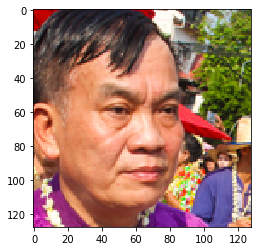

After alignment


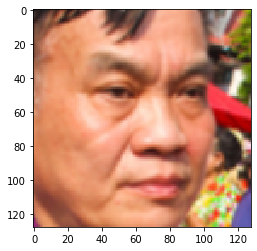

In [6]:
img = io.imread('img/sample1.png')
t1 = timeit.default_timer()
result = face_alignment(img, scale = 1.05)

print('Time elapsed: {}'.format(timeit.default_timer() - t1))

print('Original image')
plt.imshow(img)
plt.show()

print('After alignment')
plt.imshow(result[0])
plt.show()

## 2. Face_alignment

In [90]:
import face_alignment
from skimage import io

# NVIDIA GPU가 없어서 ERROR
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, flip_input=False)

input = io.imread('input/sample1.png')
preds = fa.get_landmarks(input)

AssertionError: Torch not compiled with CUDA enabled